<a href="https://colab.research.google.com/github/pascal-maker/segment-anything/blob/main/sam2ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Clone the SAM 2 repository
!git clone https://github.com/facebookresearch/segment-anything-2.git

# Step 2: Navigate to the directory and install the package
%cd segment-anything-2
!pip install -e .

# Step 3: Install additional dependencies (Jupyter and Matplotlib)
!pip install -e ".[demo]"

# Step 4: Download model checkpoints
!cd checkpoints && ./download_ckpts.sh && cd ..

# Step 5: (Optional) Check if CUDA is available
import torch
torch.cuda.is_available()

# After completing the steps above, you should be able to use SAM 2 in Google Colab.


fatal: destination path 'segment-anything-2' already exists and is not an empty directory.
/content/segment-anything-2
Obtaining file:///content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=SAM_2-1.0-0.editable-cp310-cp310-linux_x86_64.whl size=12322 sha256=e481ca2fb2c057b760603715b093e86809ac0657832e6d12c414148ac301ae47
  Stored in directory: /tmp/pip-ephem-wheel-cache-1dl8_9bn/wheels/7d/af/fe/c05425a1fdc391329545b53111d5cabdfc241ee07cab053945
Successfully built SAM-2
  Attempting uninstall: SAM-2
    Found existing installation: SAM-2 1.0
    Uninstalling SAM-2-1.0:
      Successfully uninstalled SAM-2-1.0
Obtaining file:///content/segment-anything-2
  Installing build dependencies ... done
  Checking if build back

True

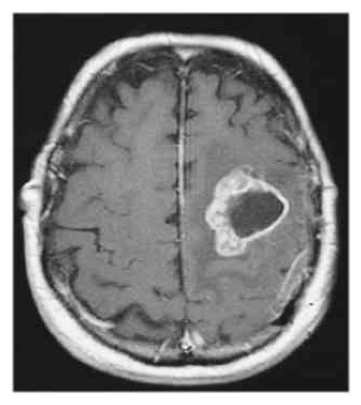

IndexError: list index out of range

In [9]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Function to capture coordinates on a click
coords = []

def onclick(event):
    global coords
    # Get the x and y coordinates where the click occurred
    ix, iy = event.xdata, event.ydata
    coords.append((ix, iy))
    print(f"Coordinates selected: ({ix:.2f}, {iy:.2f})")

    # Stop capturing after one click (if only one point is needed)
    if len(coords) >= 1:
        plt.close()

# Load and display the MRI image for manual coordinate selection
image_path = "/content/Y10.jpg"
image = Image.open(image_path).convert("RGB")  # Convert to RGB if needed

# Display the image and set up the click event
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(image, cmap='gray')
plt.axis('off')  # Hide axis

# Connect the click event to the function
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

# Output the selected coordinates
selected_coords = coords[0]  # Get the first selected coordinate

# Use the selected coordinates for SAM 2 input prompts
point_coords = [[selected_coords[0], selected_coords[1]]]
point_labels = [1]  # Label the point as foreground (1 for tumor)

# Define the paths for the checkpoint and the model configuration
checkpoint = "/content/segment-anything-2/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"  # Using the model config file directly

# Build the SAM 2 model and create the predictor
model = build_sam2(model_cfg, checkpoint)
predictor = SAM2ImagePredictor(model)

# Set the image for prediction
predictor.set_image(image)

# Prepare the input prompts
input_prompts = {
    "point_coords": torch.tensor(point_coords),
    "point_labels": torch.tensor(point_labels)
}

# Generate predictions using the selected coordinates
with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    masks, _, _ = predictor.predict(input_prompts)

# The output masks can now be used as needed


In [11]:
import torch
from sam2.build_sam import build_sam2_video_predictor

# Define the paths for the checkpoint and model configuration
checkpoint = "/content/segment-anything-2/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

# Build the SAM2 video predictor
predictor = build_sam2_video_predictor(model_cfg, checkpoint)

# Path to your video file
video_path = "/content/football_result (1).mp4"

# Run inference
with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    # Initialize the predictor state with the video
    state = predictor.init_state(video_path)

    # Define prompts for the model (example prompts)
    # Replace with actual prompts based on your needs
    prompts = {
        'points': [[100, 150]],  # Example: list of coordinates (x, y)
        'boxes': [[50, 100, 200, 250]],  # Example: list of bounding boxes (x1, y1, x2, y2)
        'labels': [1]  # Example: labels for the prompts (1 for foreground, 0 for background)
    }

    # Add new points or boxes to the model
    frame_idx, object_ids, masks = predictor.add_new_points_or_box(state, prompts)

    # Propagate the prompts to get masklets throughout the video
    for frame_idx, object_ids, masks in predictor.propagate_in_video(state):
        # Process the output masks (e.g., save, display, or analyze)
        print(f"Frame {frame_idx}: Detected object IDs: {object_ids}, Masks: {masks}")

        # Additional code to handle masks
        # Example: Save masks as images, display, or analyze
        # You may need to convert masks to a visualizable format


NotImplementedError: Only JPEG frames are supported at this moment. For video files, you may use ffmpeg (https://ffmpeg.org/) to extract frames into a folder of JPEG files, such as 
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from 00000.jpg.